# Set up the Python environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import os
from dotenv import load_dotenv

current_dir = os.getcwd()
dotenv_path = os.path.join(current_dir, '..', 'backend', '.env')

load_dotenv(dotenv_path=dotenv_path)

my_variable = os.getenv('MY_VARIABLE')
database_url = os.getenv('DATABASE_URL')

user = os.getenv('DB_USER')
pw   = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
db   = os.getenv('DB_NAME')

engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}/{db}")

### Define the time period of the data

In [2]:
start_date = pd.to_datetime('2024-01-01')
end_date   = pd.to_datetime('2025-12-31')

# Load tables into DataFrames

In [3]:
df_products      = pd.read_sql_table("Product",      con=engine)
df_users         = pd.read_sql_table("Users",        con=engine)
df_stock_entry   = pd.read_sql_table("StockEntry",   con=engine)
df_stock_withd   = pd.read_sql_table("StockWithdrawal", con=engine)
df_orders        = pd.read_sql_table("Orders",       con=engine)
df_order_info    = pd.read_sql_table("OrderInfo",    con=engine)
df_returns       = pd.read_sql_table("ReturnExchange",     con=engine)
df_return_info   = pd.read_sql_table("ReturnExchangeInfo", con=engine)
df_audit         = pd.read_sql_table("AuditLog",     con=engine)

# Compute COGS per product

In [4]:
# 2a. Only “paid” orders
paid_orders = df_orders[df_orders['paymentStatus']=='paid']

# 2b. Join orders → order lines → product costs
sales = (
    paid_orders[['orderId', 'dateOrdered']]
    .merge(df_order_info, on='orderId')
    .merge(df_products[['productId', 'cost', 'productName']], on='productId')
)

# 2c. Filter to period and compute COGS
sales['dateOrdered'] = pd.to_datetime(sales['dateOrdered'])
sales_period = sales[(sales['dateOrdered'] >= start_date) & (sales['dateOrdered'] <= end_date)]
sales_period['cogs'] = sales_period['quantity'] * sales_period['cost']

# 2d. Total COGS per product
cogs_per_prod = (sales_period
    .groupby(['productId','productName'])['cogs']
    .sum()
    .rename('total_cogs')
    .reset_index()
)


## Compute beginning & ending inventory levels

In [5]:
# 3a. Beginning on-hand = total received – total withdrawn **before** start_date
# Map withdrawals → productId
withdrawals = (
    df_stock_withd[['entryId','quantityWithdrawn','dateWithdrawn']]
    .merge(df_stock_entry[['entryId','productId']], on='entryId')
)
# Sum
received_before = (df_stock_entry[df_stock_entry['dateReceived'] < start_date]
    .groupby('productId')['quantityReceived']
    .sum()
    .rename('total_received_before')
)
withdrawn_before = (withdrawals[pd.to_datetime(withdrawals['dateWithdrawn']) < start_date]
    .groupby('productId')['quantityWithdrawn']
    .sum()
    .rename('total_withdrawn_before')
)
beg_inv = (received_before.subtract(withdrawn_before, fill_value=0)
           .reset_index().rename(columns={0:'beg_units', 'total_received_before':'beg_units'}))

# 3b. Ending on-hand from current snapshot
end_inv = df_products[['productId','productName','stockOnHand','cost']]


## Build the turnover table

In [6]:
# Merge beginning, ending, and COGS
turnover = (
    cogs_per_prod
    .merge(beg_inv,  on=['productId'], how='left')
    .merge(end_inv,  on=['productId','productName'], how='left')
    .fillna(0)
)

# Average units and average inventory **value**
turnover['avg_units'] = (turnover['beg_units'] + turnover['stockOnHand']) / 2
turnover['avg_inventory_value'] = turnover['avg_units'] * turnover['cost']

# Turnover rate per product
turnover['turnover_rate'] = turnover['total_cogs'] / turnover['avg_inventory_value']


/var/folders/hv/jnmd_b7123gfd5f464464gh80000gn/T/ipykernel_83696/588882686.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


## Visualize: Top 10 Products by Turnover Rate

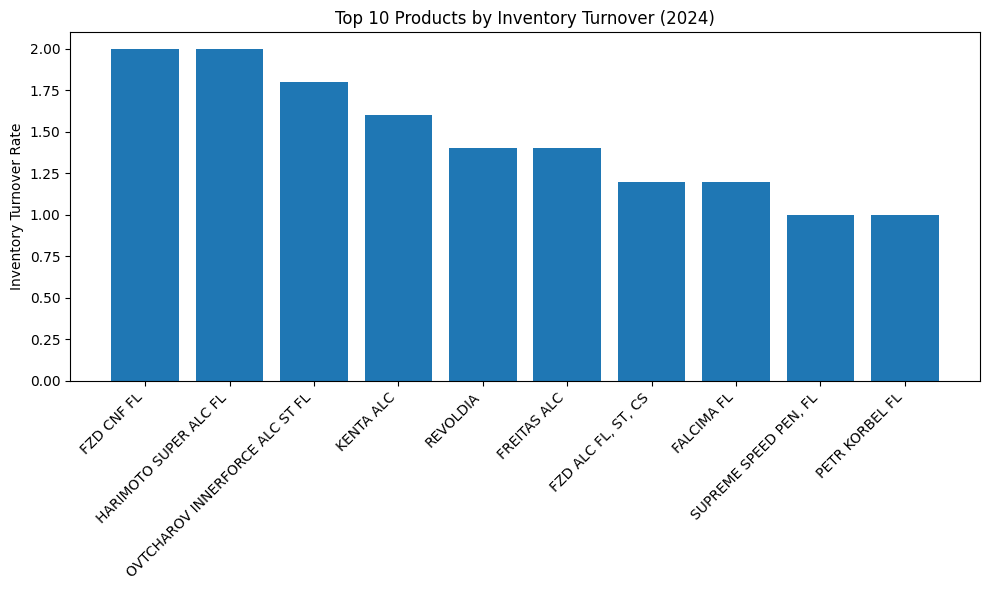

In [7]:
top10 = turnover.sort_values('turnover_rate', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10['productName'], top10['turnover_rate'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Inventory Turnover Rate')
plt.title('Top 10 Products by Inventory Turnover (2024)')
plt.tight_layout()
plt.show()


# Stock-level snapshots

## Current Monetary Stock Value

In [9]:
# add a column for the value on hand per product
df_products['monetaryValue'] = df_products['stockOnHand'] * df_products['cost']

# overall monetary value
current_monetary_value = df_products['monetaryValue'].sum()
print(f"Current monetary stock value: ₱{current_monetary_value:,.2f}")


Current monetary stock value: ₱13,163,351.62


## Total Items in Stock

In [10]:
total_items = df_products['stockOnHand'].sum()
print(f"Total units in stock: {total_items:,}")


Total units in stock: 6,395


## Low-Stock Alerts

     productId               productName  stockOnHand
0            1   LIN YUN JU SUPER ZLC FL           10
1            2  FZD SUPER ALC FL, ST, CS           10
2            3                FZD CNF FL           10
3            4     SUPER ALC VISCARIA FL           10
4            5              TIMOBOLL ZLC           10
..         ...                       ...          ...
406        407                Product 26            5
412        413                Product 32            3
414        415                Product 34            1
422        423                Product 42            1
429        430                Product 49            6

[389 rows x 3 columns]


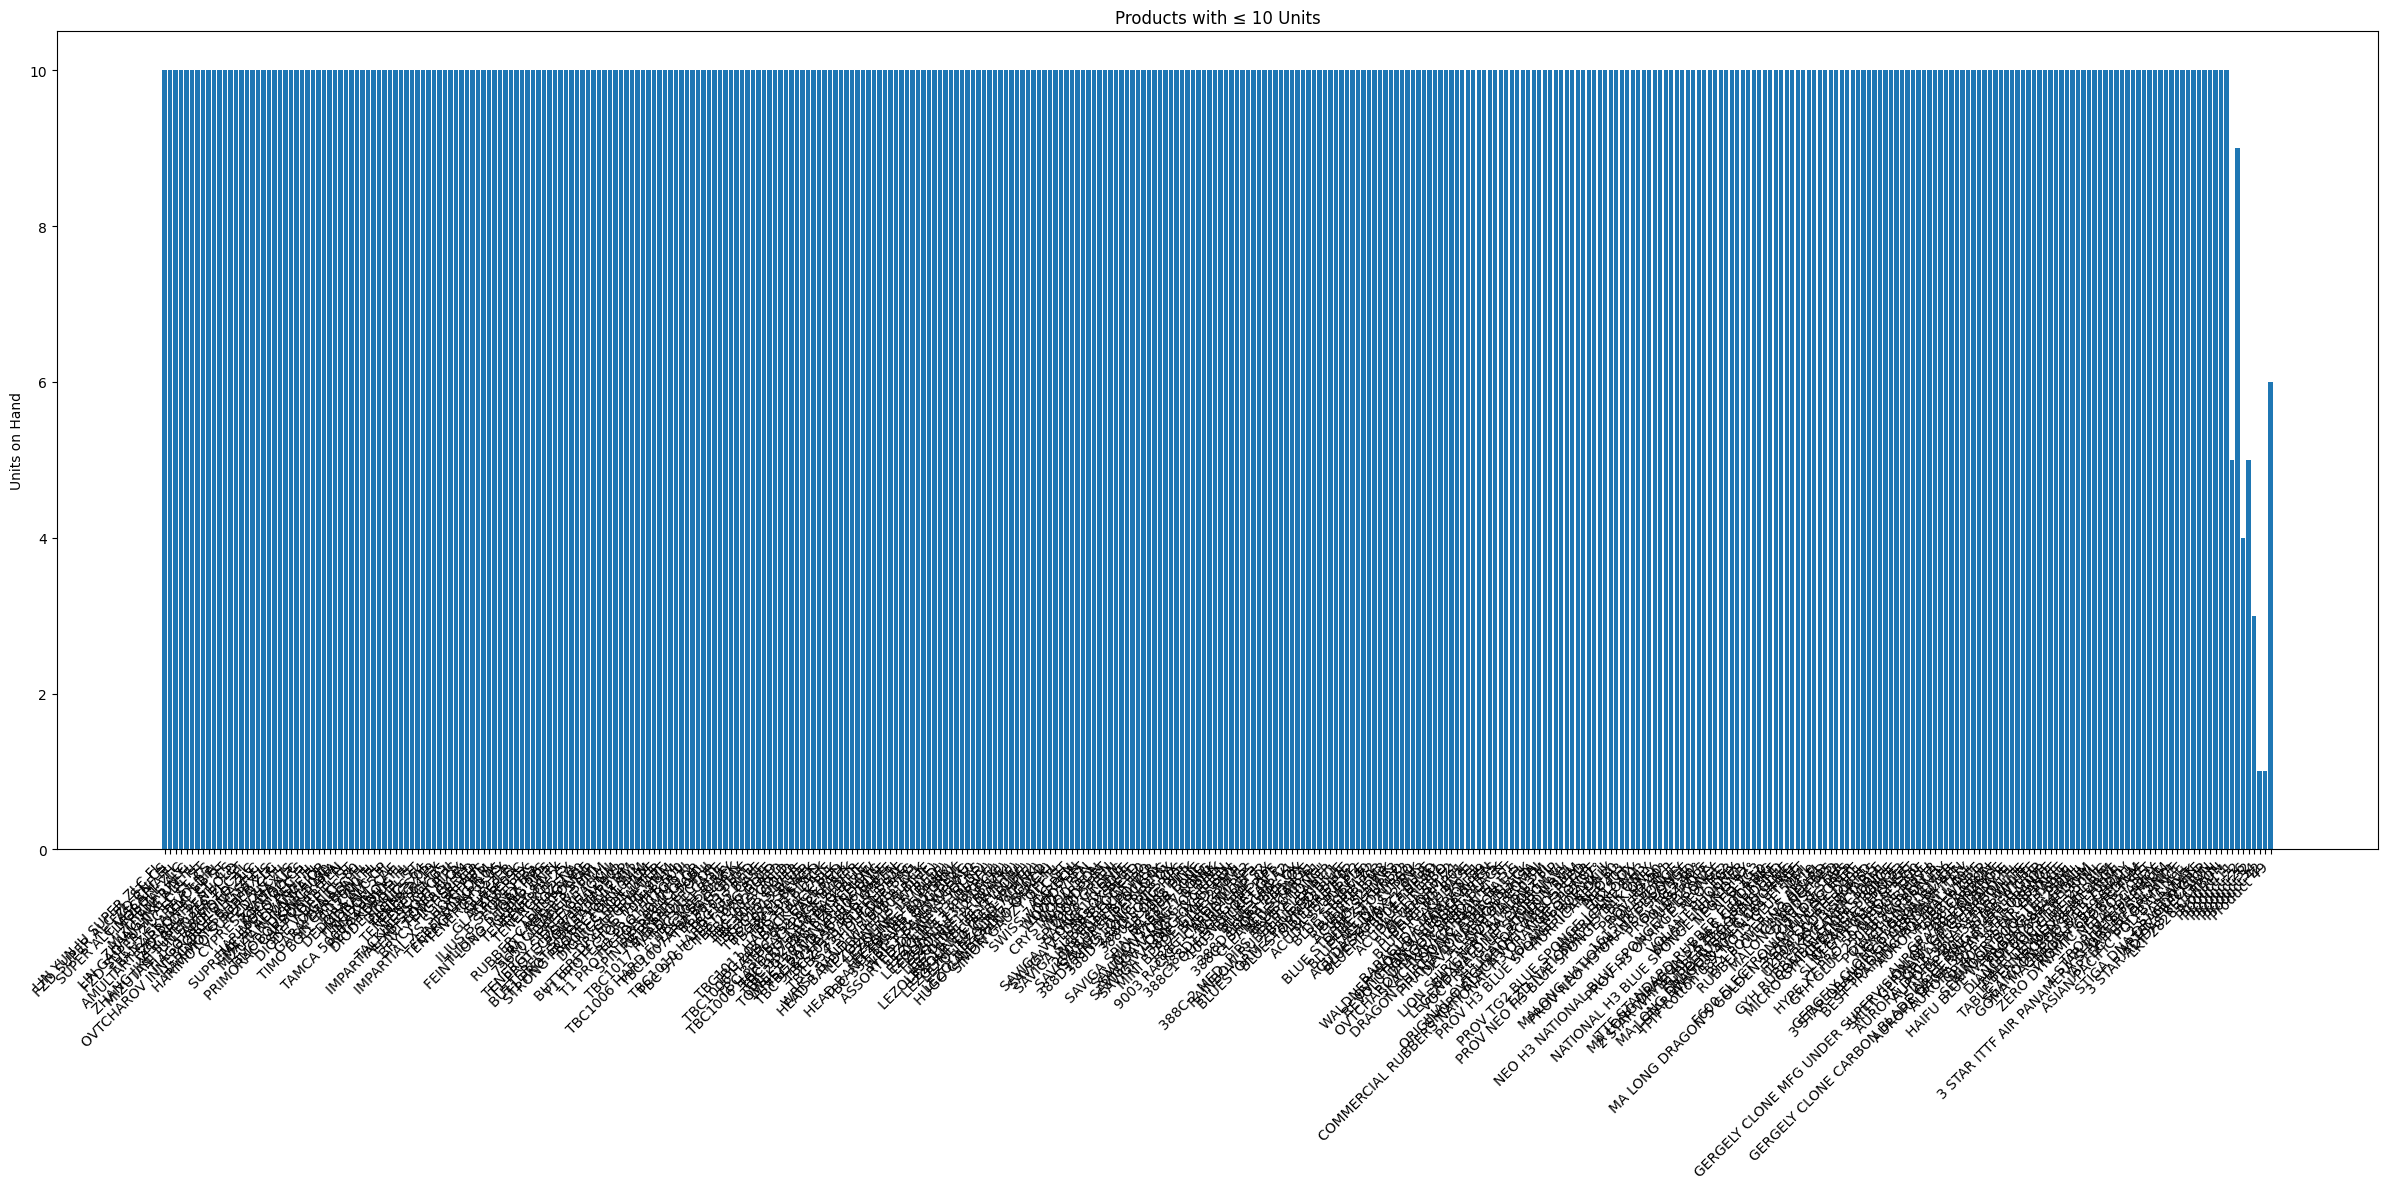

In [12]:
low_stock_threshold = 10
low_stock = df_products[df_products['stockOnHand'] <= low_stock_threshold]

# list
print(low_stock[['productId','productName','stockOnHand']])

# bar chart
plt.figure(figsize=(24,12))
plt.bar(low_stock['productName'], low_stock['stockOnHand'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Units on Hand')
plt.title(f'Products with ≤ {low_stock_threshold} Units')
plt.tight_layout()
plt.show()


## Out‐of‐Stock Items

In [13]:
out_of_stock = df_products[df_products['stockOnHand'] == 0]
print(out_of_stock[['productId','productName']])


Empty DataFrame
Columns: [productId, productName]
Index: []


## Overstock Items

In [14]:
overstock_threshold = 100
overstock = df_products[df_products['stockOnHand'] >= overstock_threshold]
print(overstock[['productId','productName','stockOnHand']])


Empty DataFrame
Columns: [productId, productName, stockOnHand]
Index: []


# Deliveries, Sales & Returns

## Upcoming Deliveries

In [15]:
now = pd.Timestamp.now().normalize()
upcoming = df_stock_entry[pd.to_datetime(df_stock_entry['dateReceived']) >= now]
print(upcoming.sort_values('dateReceived')[['productId','branchName','dateReceived','quantityReceived']])


    productId branchName dateReceived  quantityReceived
29         31       Main   2025-07-20                67


## Recent Sales / Orders

In [16]:
cutoff = now - pd.Timedelta(days=30)
recent = sales[(sales['dateOrdered'] >= cutoff)]

# # orders
print(f"Paid orders in last 30d: {recent['orderId'].nunique()}")

# total revenue
recent = recent.assign(revenue = recent['quantity'] * recent['unitPriceAtPurchase'])
print(f"Sales revenue last 30d: ₱{recent['revenue'].sum():,.2f}")


Paid orders in last 30d: 17
Sales revenue last 30d: ₱5,658.60


## Returns / Damaged Goods

In [17]:
# join return header + details
returns = (
    df_returns[['transactionId','dateTransaction','transactionStatus']]
    .merge(df_return_info, on='transactionId')
    .merge(df_products[['productId','productName']], left_on='returnedProductId', right_on='productId')
)
print(returns[['transactionId','dateTransaction','productName','returnedQuantity','transactionStatus']])


    transactionId dateTransaction                     productName  \
0               1      2025-07-19                 MIZUTANI JUN FL   
1               2      2025-07-18               ZHANG JIKE ALC FL   
2               3      2025-07-17          LIN GAO YUAN ALC FL ST   
3               4      2025-07-16         FZD SUPER ZLC FL ST. CS   
4               5      2025-07-15                        REVOLDIA   
5               6      2025-07-14             FRANZISKA ZLC ST FL   
6               7      2025-07-13        AMULTART CARBON FL CP ST   
7               8      2025-07-12              FZD ALC FL, ST, CS   
8               9      2025-07-11                VISCARIA PENHOLD   
9              10      2025-07-10     ZHANG JIKE SUPER ZLC FL. ST   
10             11      2025-07-09       MIZUTANI JUN SUPER ZLC FL   
11             12      2025-07-08                    HARIMOTO ZLC   
12             13      2025-07-07              TIAGO APOLONIA ZLC   
13             14      2025-07-06 

# Movement / Velocity & Top/Slow Movers

## Stock Movement / Velocity

Daily in vs. out over the period:

Stock In vs. Stock Out (Time-series)

In [ ]:
# prepare
in_ = df_stock_entry.assign(date=pd.to_datetime(df_stock_entry['dateReceived']))
out = (
    df_stock_withd.rename(columns={'dateWithdrawn':'date','quantityWithdrawn':'qty'})
    .merge(df_stock_entry[['entryId','productId']], on='entryId')
    .assign(date=lambda d: pd.to_datetime(d['date']))
)

# aggregate & resample
daily_in  = in_.set_index('date')['quantityReceived'].resample('D').sum().fillna(0)
daily_out = out.set_index('date')['qty'].resample('D').sum().fillna(0)

# plot
plt.figure(figsize=(10,4))
plt.plot(daily_in.index, daily_in, label='In')
plt.plot(daily_out.index, daily_out, label='Out')
plt.legend(); plt.title('Daily Stock Movement'); plt.tight_layout()
plt.show()


## Top-Selling Products


by quantity

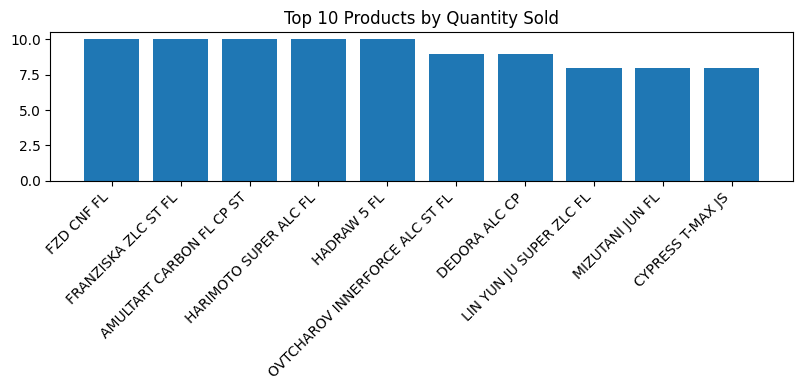

In [18]:
top_qty = (
    df_order_info
    .groupby('productId')['quantity']
    .sum()
    .nlargest(10)
    .reset_index()
    .merge(df_products[['productId','productName']], on='productId')
)
plt.figure(figsize=(8,4))
plt.bar(top_qty['productName'], top_qty['quantity'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Quantity Sold')
plt.tight_layout()
plt.show()


by revenue

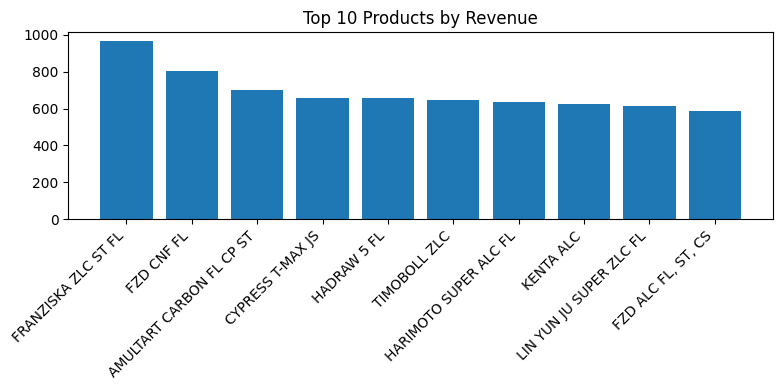

In [19]:
rev = df_order_info.assign(revenue=df_order_info['quantity']*df_order_info['unitPriceAtPurchase'])
top_rev = (
    rev.groupby('productId')['revenue']
    .sum()
    .nlargest(10)
    .reset_index()
    .merge(df_products[['productId','productName']], on='productId')
)
plt.figure(figsize=(8,4))
plt.bar(top_rev['productName'], top_rev['revenue'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()


## Slow-Moving / Obsolete Stock

no sales in last 90 days

In [20]:
last_sale = (
    sales.groupby('productId')['dateOrdered']
    .max()
    .reset_index()
    .assign(days_since = (now - pd.to_datetime(lambda d: d['dateOrdered'])).dt.days)
)
slow = last_sale[last_sale['days_since'] > 90].merge(df_products[['productId','productName','stockOnHand']], on='productId')
print(slow[['productName','stockOnHand','days_since']])


TypeError: <class 'function'> is not convertible to datetime, at position 0

# Fulfillment & Inventory Ratios

## Order Fulfillment Rate

If “paid” = fulfilled IDK AAAAAAAA

In [21]:
total_orders = df_orders.shape[0]
fulfilled    = paid_orders.shape[0]
rate = fulfilled / total_orders * 100
print(f"Fulfillment Rate: {rate:.1f}%")


Fulfillment Rate: 34.0%


## Inventory Turnover Rate

In [23]:
overall_turnover = sales_period['cogs'].sum() / turnover['avg_inventory_value'].sum()
print(f"Overall Inv. Turnover Rate: {overall_turnover:.2f}")


Overall Inv. Turnover Rate: 1.23


## Days Sales of Inventory (DSI) / Days on Hand

In [24]:
period_days = (end_date - start_date).days
total_cogs = sales_period['cogs'].sum()
avg_inv_val = turnover['avg_inventory_value'].sum()
DSI = avg_inv_val / (total_cogs / period_days)
print(f"Days Sales of Inventory: {DSI:.1f} days")


Days Sales of Inventory: 595.7 days


## Reorder Point & Safety Stock

In [25]:
# avg daily usage per product
daily_usage = sales_period.groupby('productId')['quantity'].sum() / period_days

lead_time_days = 7  # example
# assume safety_stock pre‐computed or constant:
safety_stock = 20

reorder_point = (daily_usage * lead_time_days + safety_stock).rename('reorderPoint').reset_index()
print(reorder_point.merge(df_products[['productId','productName']], on='productId'))


    productId  reorderPoint                     productName
0           3     20.095890                      FZD CNF FL
1           6     20.067123                     FREITAS ALC
2           9     20.038356          LIN GAO YUAN ALC FL ST
3          11     20.067123                        REVOLDIA
4          14     20.057534              FZD ALC FL, ST, CS
5          17     20.019178       MIZUTANI JUN SUPER ZLC FL
6          20     20.086301  OVTCHAROV INNERFORCE ALC ST FL
7          23     20.095890           HARIMOTO SUPER ALC FL
8          26     20.076712                       KENTA ALC
9          29     20.047945           SUPREME SPEED PEN, FL
10         32     20.009589                      DIGNICS090
11         35     20.028767                  SK-7 KORBEL FL
12         38     20.038356                 GARAYDIA ALC FL
13         41     20.057534                      FALCIMA FL
14         44     20.019178                    TIMOBOLL CAF
15         47     20.047945             

## Safety Stock Calculation

Using service‐level z and usage variability

In [26]:
import numpy as np

# daily usage series
du = sales.set_index('dateOrdered').groupby('productId')['quantity'].resample('D').sum().fillna(0)
std_usage = du.groupby('productId').std()

z = 1.65  # ~95% service level
ss = (z * std_usage * np.sqrt(lead_time_days)).rename('safetyStock').reset_index()
print(ss.head())


   productId  safetyStock
0          3          NaN
1          6          NaN
2          9          NaN
3         11          NaN
4         14          NaN


## ABC Analysis

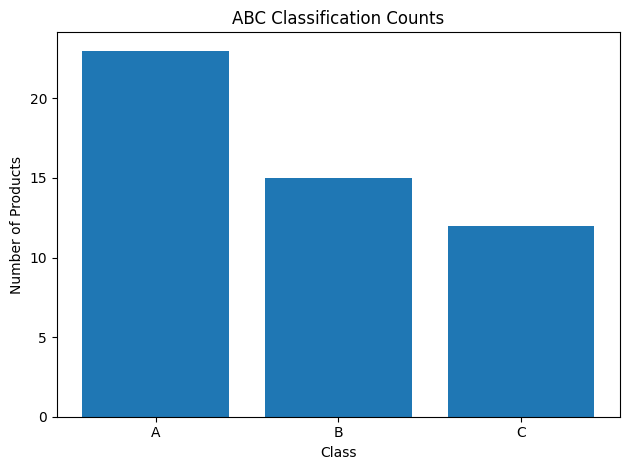

In [27]:
# revenue per product
rev_tot = rev.groupby('productId')['revenue'].sum().reset_index()
rev_tot = rev_tot.merge(df_products[['productId','productName']], on='productId').sort_values('revenue', ascending=False)
rev_tot['cumPct'] = rev_tot['revenue'].cumsum() / rev_tot['revenue'].sum() * 100

conds = [
    rev_tot['cumPct'] <= 80,
    rev_tot['cumPct'].between(80,95),
    rev_tot['cumPct'] > 95
]
choices = ['A','B','C']
rev_tot['ABC'] = np.select(conds, choices, default='C')

# count per class
abc_counts = rev_tot['ABC'].value_counts().sort_index()
plt.figure()
plt.bar(abc_counts.index, abc_counts.values)
plt.title('ABC Classification Counts')
plt.xlabel('Class'); plt.ylabel('Number of Products')
plt.tight_layout()
plt.show()


## Demand Forecasting

Simple Holt–Winters on daily sales

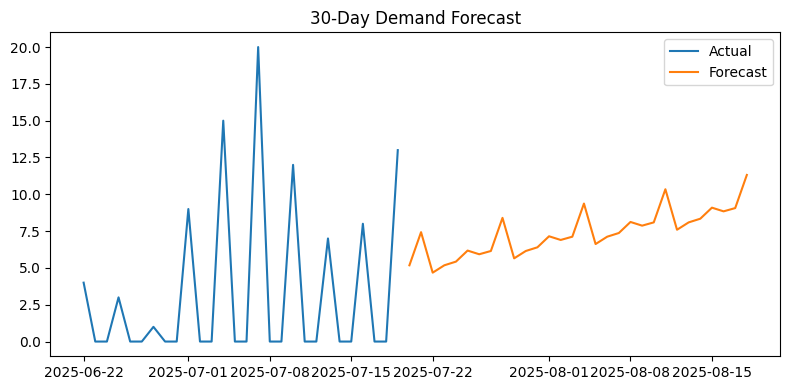

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ts = sales.groupby('dateOrdered')['quantity'].sum().resample('D').sum().fillna(0)

model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=7).fit()
forecast = model.forecast(30)

plt.figure(figsize=(8,4))
plt.plot(ts.index, ts, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(); plt.title('30-Day Demand Forecast'); plt.tight_layout()
plt.show()


## Stockout Rate / Fill Rate

Approximate days when demand > stock

In [30]:
# daily demand vs. inventory at start of day
inv_daily = df_products.set_index('productId')['stockOnHand']  # snapshot; for rolling you'd need daily snapshots
# …for true fill rate you need back‐order data

# simpler: % of order lines where stockOnHand at order < quantityOrdered
merged = df_order_info.merge(df_products[['productId','stockOnHand']], on='productId')
stockouts = (merged['stockOnHand'] < merged['quantity']).mean() * 100
print(f"Stockout Rate (order‐lines): {stockouts:.1f}%")


Stockout Rate (order‐lines): 0.0%


## ROI of Inventory

In [31]:
gross = rev.assign(cogs = df_order_info['quantity'] * df_products.set_index('productId').loc[df_order_info['productId'],'cost'])
total_rev = gross['revenue'].sum()
total_cogs = gross['cogs'].sum()
avg_inv_val = turnover['avg_inventory_value'].sum()

ROI = (total_rev - total_cogs) / avg_inv_val * 100
print(f"Inventory ROI: {ROI:.1f}%")


Inventory ROI: -288.8%


## Obsolete Inventory / Shrinkage

to check if certain items are obsolete na, not morving stock
pero to do that, we need to count the products that are physically present in one store

sige wag na lang siguro muna

In [ ]:
# # df_physical with columns productId, countedUnits
# shrink = df_physical.set_index('productId')['countedUnits'] - df_products.set_index('productId')['stockOnHand']
# print(shrink.sort_values().head(10))  # largest negative = biggest shrinkage


NameError: name 'df_physical' is not defined